In [110]:
#Library Imports

import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import datetime as dt
import requests
from datetime import date
from varclushi import VarClusHi
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [111]:
# Raw Data Collection

# Definition of parameters for API Call
params = {
  'access_key': 'D3BD1V1XVCUGQQ2XGZIGF4F52AE2ROYH',
  'periodType' : 'year',
  'period' : '10',
  'frequencyType' : 'daily',
}

# $AAPL API Call 
api_result_aapl = requests.get('https://api.tdameritrade.com/v1/marketdata/AAPL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# Comparative Assets

# $GOOGL API Call
api_result_googl = requests.get('https://api.tdameritrade.com/v1/marketdata/GOOGL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $MSFT API Call
api_result_msft = requests.get('https://api.tdameritrade.com/v1/marketdata/MSFT/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $META API Call
api_result_meta = requests.get('https://api.tdameritrade.com/v1/marketdata/META/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $SP500 API Call
api_result_sp500 = requests.get('https://api.tdameritrade.com/v1/marketdata/$SPX.X/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# Convert result to DF
def json_to_df(api_result):
    json_result = api_result.json()
    raw_data = pd.DataFrame(json_result['candles'])
    return raw_data

# Pass json to pandas data frame
raw_data_aapl = json_to_df(api_result_aapl)
raw_data_googl = json_to_df(api_result_googl)
raw_data_msft = json_to_df(api_result_msft)
raw_data_meta = json_to_df(api_result_meta)

# Join data frames together, sloppy code right now... will refract in future
data_appl_googl = pd.merge(raw_data_aapl, raw_data_googl, on=['datetime'], suffixes=('_aapl', '_googl'))
data_msft_meta = pd.merge(raw_data_meta, raw_data_msft, on=['datetime'], suffixes=('_meta', '_msft'))    
data = pd.merge(data_appl_googl, data_msft_meta, on=['datetime'])

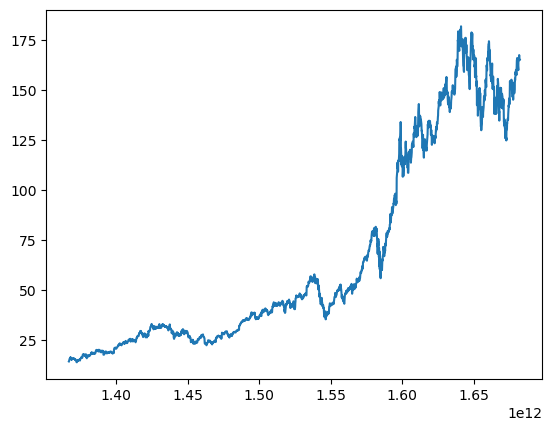

In [112]:
# Quick visualization of opening closing price over past 10 years
plt.plot(data["datetime"], data["close_aapl"])
plt.show()

In [113]:
# Check for missing data values
print(data.isnull().sum())

open_aapl       0
high_aapl       0
low_aapl        0
close_aapl      0
volume_aapl     0
datetime        0
open_googl      0
high_googl      0
low_googl       0
close_googl     0
volume_googl    0
open_meta       0
high_meta       0
low_meta        0
close_meta      0
volume_meta     0
open_msft       0
high_msft       0
low_msft        0
close_msft      0
volume_msft     0
dtype: int64


In [114]:
# Pre-process data with feature engineering to create a set of technical indicators

# Calculate relative strength index
def create_rsi(dataset, lookback):
    ret = dataset['close_aapl'].diff()
    up = ret.where(ret > 0, 0)
    down = -ret.where(ret < 0, 0)
    up_ewm = up.ewm(com=lookback-1, adjust=False).mean()
    down_ewm = down.ewm(com=lookback-1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame({'rsi': rsi}).set_index(dataset['close_aapl'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df.iloc[3:]

# Function for creating techincal indicators
def create_technical_indicators(dataset):
    # Create Simple Moving Averages
    dataset['sma7'] = dataset['close_aapl'].rolling(window=7).mean()
    dataset['sma21'] = dataset['close_aapl'].rolling(window=21).mean()
    
    # Create Simple Moving Averages Volume
    dataset['sma5_volume'] = dataset['volume_aapl'].rolling(window=5).mean()
    dataset['sma15_volume'] = dataset['volume_aapl'].rolling(window=15).mean()
    dataset['sma_volume_ratio'] = dataset['sma5_volume'] / dataset['sma15_volume']
    
    # Create Stochastic Oscillators
    dataset['lowest5'] = dataset['low_aapl'].rolling(window=5).min()
    dataset['highest5'] = dataset['high_aapl'].rolling(window=5).max()
    dataset['lowest15'] = dataset['low_aapl'].rolling(window=15).min()
    dataset['highest15'] = dataset['high_aapl'].rolling(window=15).max()

    dataset['stochastic5'] = ((dataset['close_aapl'] - dataset['lowest5']) / (dataset['highest5'] - dataset['lowest5'])) * 100
    dataset['stochastic15'] = ((dataset['close_aapl'] - dataset['lowest15']) / (dataset['highest15'] - dataset['lowest15'])) * 100

    dataset['stochastic5mean'] = dataset['stochastic5'].rolling(window = 5).mean()
    dataset['stochastic15mean'] = dataset['stochastic15'].rolling(window = 15).mean()

    dataset['stochastic_ratio'] = dataset['stochastic5mean'] / dataset['stochastic15mean']
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['close_aapl'].rolling(20).std()
    dataset['upper_band'] = dataset['sma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['sma21'] - (dataset['20sd'] * 2)
    
    # Create Exponential moving average
    dataset['ema26'] = dataset['close_aapl'].ewm(span=26).mean()
    dataset['ema12'] = dataset['close_aapl'].ewm(span=12).mean()
    dataset['ema'] = dataset['close_aapl'].ewm(com=0.5).mean()
    
    # Create MACD
    dataset['macd'] = (dataset['ema12'] - dataset['ema26'])
    
    # Create Momentum
    dataset['momentum'] = dataset['close_aapl'] - 1
    
    # Create RSI
    dataset['rsi_5'] = create_rsi(dataset, 5)
    dataset['rsi_15'] = create_rsi(dataset, 15)
    dataset['rsi_ratio'] = dataset['rsi_5'] / dataset['rsi_15']
    
    # Create Average True Range
    dataset['tr'] = np.maximum((dataset['high_aapl'] - dataset['low_aapl']), np.maximum(abs(dataset['high_aapl'] - dataset['close_aapl'].shift(1)), abs(dataset['close_aapl'].shift(1) - dataset['low_aapl'])))
    dataset['atr'] = dataset['tr'].rolling(window = 14).mean()
    
    # Create Rate of Change
    dataset['roc'] = dataset['close_aapl'].pct_change(periods=15)
    
    return dataset

# Assign row numbers
data = data.assign(row_number=range(len(data)))

# Convert from seconds since epoch to datetime
data['datetime'] = pd.to_datetime(data['datetime'],unit='ms')

# Create technical indicators for $AAPl
data = create_technical_indicators(data)

In [115]:
# Dataset shape overview
print(data.shape)
data = data.dropna()
print(data.shape)

(2518, 50)
(2490, 50)


In [116]:
data

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,datetime,open_googl,high_googl,low_googl,close_googl,...,ema12,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc
28,16.186429,16.229643,15.978214,16.046786,292726084,2013-06-04 05:00:00,21.717275,21.785842,21.372442,21.498313,...,15.943232,16.058789,0.055571,15.046786,59.542601,59.405842,1.002302,0.251428,0.395867,-0.011941
29,15.916071,16.097143,15.846786,15.896786,290589348,2013-06-05 05:00:00,21.583646,21.757314,21.449016,21.513328,...,15.936038,15.950787,0.047627,14.896786,43.934826,55.034442,0.798315,0.250357,0.358903,0.002816
30,15.909643,15.964286,15.501786,15.659286,417073832,2013-06-06 05:00:00,21.628439,21.679239,21.201026,21.636948,...,15.893220,15.756453,0.023501,14.659286,28.927428,48.926797,0.591239,0.462500,0.343597,0.022409
31,15.589286,15.830000,15.456072,15.778964,404742744,2013-06-07 05:00:00,21.781588,22.021320,21.653964,22.014563,...,15.875558,15.771460,0.013187,14.778964,41.511698,51.813991,0.801168,0.373928,0.347143,0.016644
32,15.883214,16.038536,15.600000,15.674643,450356172,2013-06-10 05:00:00,22.073871,22.296586,22.023574,22.277068,...,15.844523,15.706915,-0.002751,14.674643,34.798179,49.215588,0.707056,0.438536,0.338416,0.012994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,166.100000,167.410000,165.650000,166.470000,49923008,2023-04-18 05:00:00,106.490000,106.540000,104.070000,104.500000,...,163.538749,166.005724,3.019530,165.470000,70.225851,64.208801,1.093711,2.180000,2.802029,0.051744
2514,165.800000,168.160000,165.540000,167.630000,47720166,2023-04-19 05:00:00,103.580000,104.980000,103.070000,104.180000,...,164.168173,167.088575,3.122229,166.630000,75.225372,65.918121,1.141194,2.620000,2.746314,0.063305
2515,166.090000,167.870000,165.560000,166.650000,52456377,2023-04-20 05:00:00,103.910000,106.250000,103.868400,105.290000,...,164.549992,166.796192,3.088933,165.650000,63.895225,63.186607,1.011215,2.310000,2.789886,0.036574
2516,165.050000,166.452100,164.490000,165.020000,58337341,2023-04-21 05:00:00,105.470000,106.000000,104.780000,105.410000,...,164.622301,165.612064,2.897617,164.020000,48.658238,58.841437,0.826938,2.160000,2.723457,0.016383


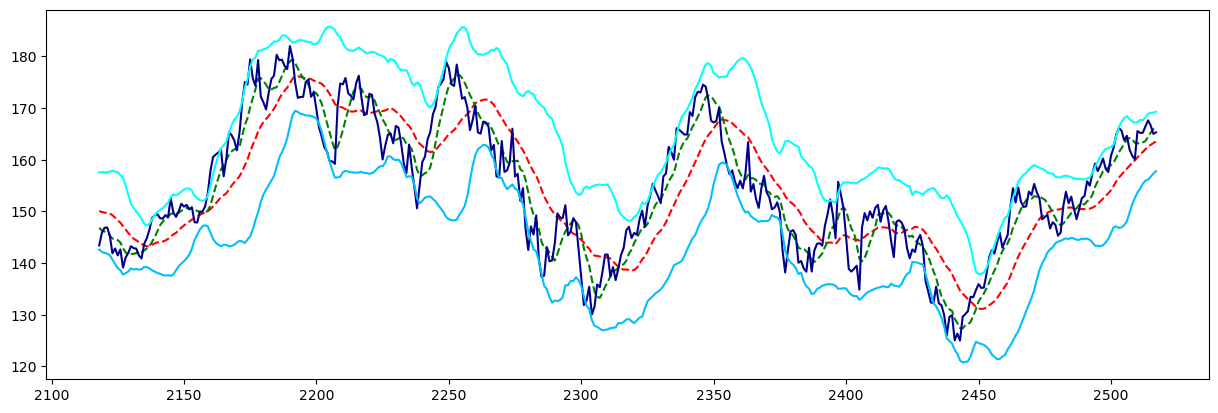

In [117]:
# Exploratory analysis of technical indicators
last400days = data.iloc[-400:]
plt.figure().set_figwidth(15)
plt.plot(last400days["row_number"], last400days["sma21"], color='red', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["sma7"], color='green', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["close_aapl"], color='darkblue')
plt.plot(last400days["row_number"], last400days["upper_band"], color='cyan')
plt.plot(last400days["row_number"], last400days["lower_band"], color='deepskyblue')
plt.show()

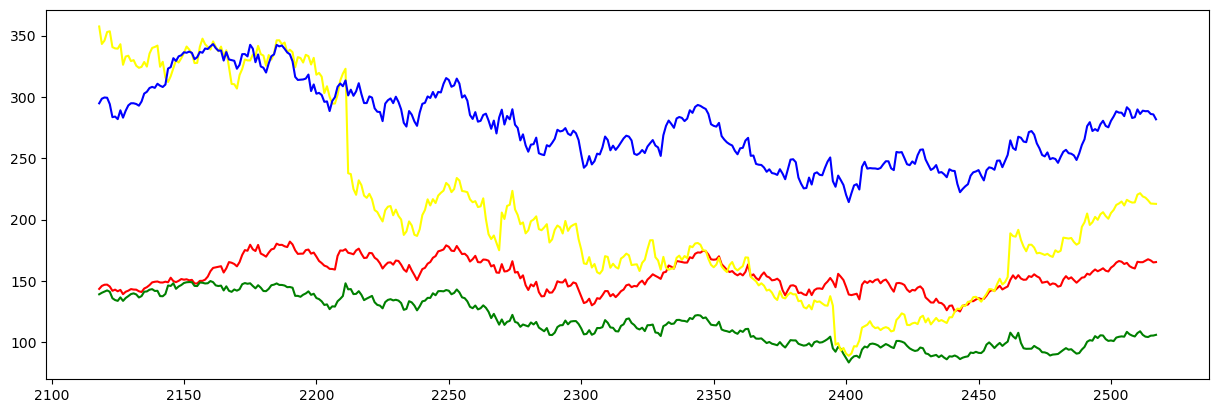

In [118]:
# Closing Price of $APPL vs comparative assets
plt.figure().set_figwidth(15)
plt.plot(last400days["row_number"], last400days["close_aapl"], color='red')
plt.plot(last400days["row_number"], last400days["close_googl"], color='green')
plt.plot(last400days["row_number"], last400days["close_meta"], color='yellow')
plt.plot(last400days["row_number"], last400days["close_msft"], color='blue')
plt.show()

In [119]:
# Export raw data to CSV file
filename = "stockdata_" + str(date.today()) + ".csv"
data.to_csv("data/" + filename, index=False)

In [120]:
# Use Varclushi for feature importance and reduction

#Drop row number columns and close_aapl price for feature correlation
feature_data = data.drop(columns='close_aapl')
feature_data = feature_data.drop(columns='row_number')
feature_data = feature_data.drop(columns='datetime')

data_vc = VarClusHi(feature_data, maxeigval2 = 1, maxclus = None)
data_vc.varclus()
data_vc.info

,Cluster,N_Vars,Eigval1,Eigval2,VarProp
0,0,26,24.745554,0.698154,0.951752
1,1,6,4.146534,0.993214,0.691089
2,2,4,3.998732,0.000716,0.999683
3,3,5,3.377365,0.944842,0.675473
4,4,5,3.426893,0.762093,0.685379
5,5,1,1.000000,0.000000,1.000000


In [121]:
# As demonstrated above, varclushi appears to cluster the technical/basic indicators of each individual asset together
# As such, relying on this for feature reduction does not serve as necessarily as a viable option
# We plan to review additional feature reduction methods as we begin to port the dataset into the model to determine
# what yields the best results

In [122]:
# PCA Feature Reduction
data_pca = feature_data.values
data_pca = (data_pca - data_pca.mean()) / data_pca.std()

# Fit PCA with all features
pca = PCA()
pca.fit(data_pca)

# Check explained variance ratios for each component
explained_variances = pca.explained_variance_ratio_
print(explained_variances)

[8.59511837e-01 7.99878605e-02 2.29546064e-02 2.01367001e-02
 1.14019486e-02 6.00704740e-03 2.12251422e-12 2.81437340e-13
 9.54087952e-14 2.10766085e-14 1.57139950e-14 7.98572194e-15
 5.91193445e-15 3.51096476e-15 1.63352383e-15 6.32796134e-16
 5.05268648e-16 3.55712367e-16 2.27154126e-16 1.03635350e-16
 8.28933507e-17 6.13503429e-17 5.80967391e-17 4.33498889e-17
 3.23417109e-17 2.84643460e-17 2.53863188e-17 1.96530773e-17
 1.61132493e-17 1.26528628e-17 8.09008712e-18 7.36166811e-18
 6.63217333e-18 3.69904416e-18 3.61083708e-18 2.83842203e-18
 2.42891276e-18 1.80898861e-18 1.24428106e-18 1.10830813e-18
 7.00177557e-19 2.17116458e-19 8.25297204e-20 2.39141502e-20
 5.94015967e-33 5.94015967e-33 5.94015967e-33]


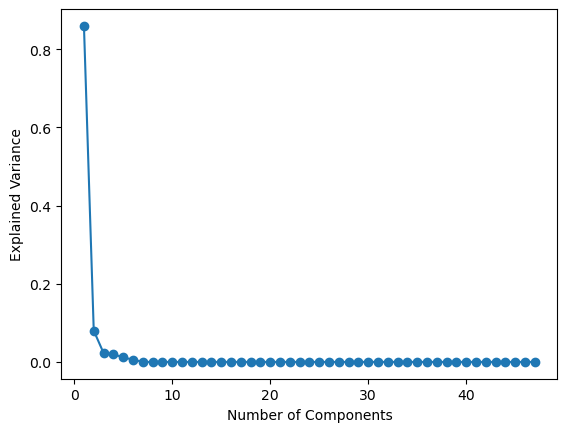

In [123]:
# Visualize explained variance ratios
import matplotlib.pyplot as plt
plt.plot(range(1, 48), explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [124]:
# The plot above demonstrates our first component explains > 80% of the result, as such
# it seems that 

In [125]:
# Given the results from above, we shift our focus to autoencoding features then attempting to feature engineer the resulting variables

In [126]:
# Attempt at autoencoding, not working how I intended

# # Encode categorical features

# #Drop row number columns and close_aapl price for feature correlation
# feature_data_encoding = data.drop(columns='row_number')
# feature_data_encoding = data.drop(columns='datetime')

# # Split the data into features and target
# X = feature_data_encoding.drop('close_aapl', axis=1)
# y = feature_data_encoding['close_aapl']

# # Define the autoencoder model
# model = MLPRegressor(hidden_layer_sizes=(10, 5, 2, 5, 10), activation='relu', solver='adam', max_iter=1000)

# # Fit the model to the data
# model.fit(X, X)

# # Encode the features using the autoencoder model
# X_auto = model.predict(X)

# # Create a new dataframe with the encoded features and target
# X_auto


In [144]:
# Prep auto-encoding
auto_encode_data = data.drop(columns=['datetime', 'row_number'])

# Split into train/test 80-20 split
train, test = train_test_split(auto_encode_data, test_size=0.2, random_state=42)

train_autoencoded = train
test_autoencoded = test

# x_train, y_train = train.drop('close_aapl', axis=1), train['close_aapl']
# x_test, y_test = test.drop('close_aapl', axis=1), test['close_aapl']

In [145]:
# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_autoencoded)
test_scaled = scaler.transform(test_autoencoded)

# Build the autoencoder model
input_dim = train_scaled.shape[1]
encoding_dim = 10
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder.fit(train_scaled, train_scaled, epochs=15, batch_size=32, validation_data=(test_scaled, test_scaled))

# Use the encoder to generate encoded data
encoder_model = keras.Model(inputs=input_layer, outputs=encoder)
encoded_train = encoder_model.predict(train_scaled)
encoded_test = encoder_model.predict(test_scaled)

# Convert the encoded data back to a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=['encoded_{}'.format(i) for i in range(encoding_dim)])
encoded_test_df = pd.DataFrame(encoded_test, columns=['encoded_{}'.format(i) for i in range(encoding_dim)])

# Concatenate the encoded data with the original data
encoded_train = pd.concat([train.reset_index(drop=True), encoded_train_df], axis=1)
encoded_test = pd.concat([test.reset_index(drop=True), encoded_test_df], axis=1)

Epoch 1/15
63/63 [==============================] - 0s 2ms/step - loss: 0.5012 - val_loss: 0.1657
Epoch 2/15
63/63 [==============================] - 0s 1ms/step - loss: -0.4778 - val_loss: -1.1972
Epoch 3/15
63/63 [==============================] - 0s 1ms/step - loss: -2.3213 - val_loss: -3.3683
Epoch 4/15
63/63 [==============================] - 0s 1ms/step - loss: -5.1710 - val_loss: -6.6230
Epoch 5/15
63/63 [==============================] - 0s 1ms/step - loss: -9.3363 - val_loss: -11.2783
Epoch 6/15
63/63 [==============================] - 0s 1ms/step - loss: -14.9793 - val_loss: -17.2228
Epoch 7/15
63/63 [==============================] - 0s 1ms/step - loss: -21.9461 - val_loss: -24.3499
Epoch 8/15
63/63 [==============================] - 0s 1ms/step - loss: -30.2146 - val_loss: -32.8352
Epoch 9/15
63/63 [==============================] - 0s 1ms/step - loss: -39.7536 - val_loss: -42.2726
Epoch 10/15
63/63 [==============================] - 0s 1ms/step - loss: -50.4693 - val_loss:

In [146]:
encoded_train

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,...,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,encoded_8,encoded_9
0,24.83500,24.860000,24.5625,24.5950,172572380,29.8850,29.924500,29.608500,29.6975,27334580,...,36.655647,0.000000,0.000000,37.211941,38.501369,0.000000,35.330925,0.000000,34.294819,36.486221
1,44.95000,45.135000,44.4525,44.9150,146118944,57.3035,57.502500,56.658000,57.2670,25213140,...,22.094152,6.984532,7.096519,21.513105,19.053051,4.833798,21.061190,1.848178,23.373903,23.121662
2,47.88625,48.396575,47.5750,48.1850,75045896,54.4870,54.738000,54.073760,54.3150,24586080,...,3.336756,0.000000,0.000000,4.859788,5.159793,0.000000,3.169827,0.000000,1.934667,3.307590
3,27.70000,27.937500,27.5275,27.9325,119036612,34.7000,35.011985,34.610500,34.9975,30171700,...,35.548637,0.000000,0.000000,37.230591,37.023289,0.000000,34.027443,0.000000,34.009266,35.424770
4,29.40625,29.530000,28.8275,28.8275,585908240,26.2500,26.284500,25.617500,25.6215,35821540,...,45.557880,0.000000,0.000000,44.015831,45.556507,0.000000,45.091187,0.000000,45.382328,46.970070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,65.26750,65.827500,65.1700,65.4350,67241552,65.3050,66.213500,65.152555,65.9470,35527840,...,0.000000,7.799638,8.689298,0.000000,0.000000,8.412601,0.000000,8.545511,0.000000,0.000000
1988,38.74250,38.872500,38.6400,38.8250,69630232,49.0000,49.713000,48.925500,49.6820,31060660,...,15.581437,0.000000,0.000000,20.267954,18.820011,0.000000,15.544819,0.000000,14.831800,17.199095
1989,43.76250,43.770000,43.3350,43.5225,82867208,52.9285,53.651750,52.738565,53.6005,35429820,...,9.709012,0.000000,0.000000,11.861736,10.965034,0.000000,8.502401,0.000000,7.002604,8.966847
1990,48.11250,48.415025,48.0125,48.2500,74791592,63.5500,63.750000,62.207000,62.9075,107600640,...,2.554658,0.000000,0.000000,6.637794,5.344325,0.000000,4.483285,0.000000,2.232096,3.761296


In [147]:
encoded_test

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,...,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4,encoded_5,encoded_6,encoded_7,encoded_8,encoded_9
0,39.83000,40.05250,39.6875,39.9625,88490936,46.95350,47.0520,46.724250,46.9465,23012240,...,13.929511,0.000000,0.000,15.030348,15.081471,0.000000,12.998283,0.0,11.345754,13.306480
1,33.61375,33.63500,32.3925,32.6400,475695880,28.33500,28.3915,28.048000,28.2185,37195740,...,40.327820,0.000000,0.000,38.582317,40.230312,0.000000,39.501247,0.0,39.494099,41.464424
2,35.47000,35.50000,35.1125,35.1700,69313500,42.86925,43.0100,42.676375,42.8255,21606720,...,31.813732,0.000000,0.000,31.619253,28.948635,0.000000,29.418713,0.0,30.287678,30.897867
3,30.00500,30.05750,29.8125,29.9850,168984980,26.39650,26.5345,26.282000,26.4915,33175020,...,34.114704,0.000000,0.000,34.351051,36.173332,0.000000,32.246357,0.0,30.761461,32.353069
4,39.21500,39.54000,37.4075,37.6825,382977536,51.60200,51.8835,49.059500,49.5625,104649800,...,48.624153,0.000000,0.000,47.963711,43.711727,0.000000,50.734749,0.0,55.109138,53.583336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,26.35000,26.68500,26.3375,26.6850,192243796,27.60000,27.9600,27.521500,27.9470,34793320,...,33.950417,0.000000,0.000,35.890427,37.075359,0.000000,32.765762,0.0,31.575829,33.235447
494,22.70750,22.93500,22.5475,22.5700,156144348,28.68900,29.1125,28.458000,28.6270,56886500,...,56.281406,0.000000,0.000,54.984699,52.796970,0.000000,53.814159,0.0,55.697922,54.837875
495,28.32250,28.75000,28.1225,28.3250,105497508,40.24100,40.5675,40.226555,40.3950,32572040,...,25.158211,0.000000,0.000,26.426708,26.808676,0.000000,23.589590,0.0,21.911894,24.287397
496,49.49750,49.66225,48.1450,48.3350,209571876,58.64850,58.8440,57.137500,57.7375,47839440,...,21.262260,3.200762,3.642,18.440981,17.165339,3.392843,22.294451,0.0,23.358278,23.890764
